## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-02-22 17:00:27--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Распознаётся files.grouplens.org (files.grouplens.org)… 128.101.65.152
Подключение к files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 5917549 (5,6M) [application/zip]
Сохранение в: «ml-1m.zip»

ml-1m.zip           100%[===================>]   5,64M  1,96MB/s    за 2,9s    

2025-02-22 17:00:36 (1,96 MB/s) - «ml-1m.zip» сохранён [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its 

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from implicit.als import AlternatingLeastSquares
sns.set()

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max(), df_train['item_id'].nunique(), df_train['item_id'].max()

(5365, 5364, 3010, 3009)

In [9]:
df_train.head()

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50


##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [10]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    result = df.pivot_table(values='rating', index='user_id', columns='item_id').fillna(0).values

    return result #shape ~ [n_users, n_items]

In [11]:
interactions = df_to_matrix(df_train)

In [12]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    result = coo_array(df_to_matrix(df))

    return result # coo_array

In [13]:
coo_interactions = df_to_coo(df_train)

In [14]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [15]:
from numpy.linalg import svd
from scipy.sparse.linalg import svds

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    if isinstance(interactions, np.ndarray):
        U, s, V = svd(interactions, full_matrices=True)
        S = np.zeros(interactions.shape)
        S[:len(s), :len(s)] = np.diag(s)
        if n_singular_values != -1:
            U_new = U[:, :n_singular_values]
            S_new = S[:n_singular_values, :n_singular_values]
            V_new = V[:n_singular_values, :]
            return U_new, S_new, V_new
        
    elif isinstance(interactions, coo_array):
        if n_singular_values == -1:
            U, s, V = svds(interactions)
        else:
            U, s, V = svds(interactions, k=n_singular_values)
        S = np.zeros((s.shape[0], s.shape[0]))
        S[:len(s), :len(s)] = np.diag(s)
        
    else:
        raise Exception("Неподходящий тип данных матрицы интеракций")
    
    return U, S, V

In [55]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values=n_singular_values)
    preds_matrix = U @ S @ V
    if isinstance(interactions, coo_array):
        interactions = interactions.toarray()
    no_action_before = (interactions == 0)
    filtered_interactions = np.where(no_action_before, preds_matrix, -np.inf)
    recommendations = np.argsort(-filtered_interactions, axis=1)[:, :top_k]
    return recommendations # shape ~ [n_users, top_k]

In [199]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [18]:
# функции взял из семинара

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )

def evaluate_recommender(df, model_preds, gt_col="test_interactions"):
    ndcg_values = []

    for idx, row in df.iterrows():
        gt_items = row[gt_col]
        ndcg_values.append(ndcg_metric(gt_items, row[model_preds]))

    return {"ndcg": np.mean(ndcg_values)}

In [242]:
def plot_graphs(interactions: Union[np.ndarray, coo_array], top_k: int = 100):
    # сгруппируем предсказания по юзерам
    test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
    test_df_grouped.head()

    results = []
    for n_singular_values in tqdm([1, 10, 50, 200, 1000]):
        t1 = time.time()
        recs = pd.DataFrame(make_svd_recommendations(interactions=interactions, n_singular_values=n_singular_values, top_k=top_k))
        t2 = time.time()
        if isinstance(interactions, coo_array):
            interactions = interactions.toarray()
        recommendations = pd.DataFrame({'user_id': pd.DataFrame(interactions).index, 'svd_recs': recs.apply(lambda row: list(row), axis=1)})
        train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
        ndcg = evaluate_recommender(train_test_df, model_preds='svd_recs')['ndcg']
        results.append((n_singular_values, ndcg, t2-t1))
    
    results_df = pd.DataFrame(results, columns=['n_singular_values', 'ndcg', 'time (sec)'])
    print(results_df)
    return results_df.plot(x='n_singular_values', y='ndcg')

100%|██████████| 5/5 [00:34<00:00,  7.00s/it]

   n_singular_values      ndcg  time (sec)
0                  1  0.539607    0.745806
1                 10  0.599351    8.480809
2                 50  0.580092    8.441560
3                200  0.514251    8.412430
4               1000  0.300686    8.474974


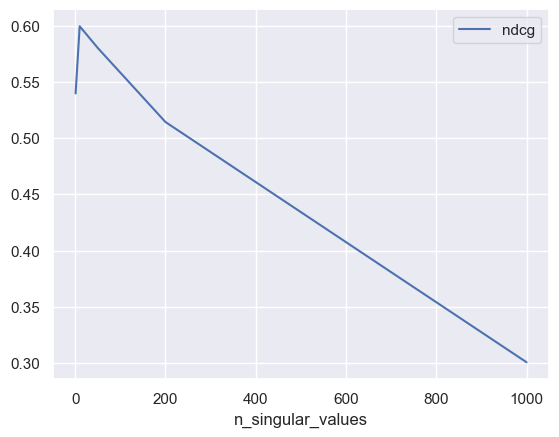

In [243]:
plot_graphs(coo_interactions)
plt.show()

`Наилучшие рекомендации получили при n_singular_values = 10 (NDCG=0.6). Время сингулярного разложени разряженных матриц напрямую зависит от количества сингулярных чисел, при этом между 10 и 1000 числами разница незначительная.`

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [19]:
from implicit.cpu.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [20]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    als = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha, random_state=42)
    if not isinstance(interactions, coo_array):
        interactions = coo_array(interactions)
    als.fit(interactions, show_progress=False)
    recommendations, scores = als.recommend(userid=pd.DataFrame(interactions.toarray()).index, user_items=csr_matrix(interactions), N=top_k, filter_already_liked_items=True)
    return recommendations  # shape ~ [n_users, top_k]

In [17]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

In [18]:
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
als_recommendations = pd.DataFrame({'user_id': pd.DataFrame(interactions).index, 'als_recs': pd.DataFrame(recs).apply(lambda row: list(row), axis=1)})
train_test_df_als = als_recommendations.merge(test_df_grouped, how='inner', on='user_id')
evaluate_recommender(train_test_df_als, model_preds='als_recs')['ndcg']

0.5523726793884726

`Из коробки получили NDCG меньше, чем при SVD разложении. Попробуем перебрать гиперпараметры.`

In [107]:
from sklearn.model_selection import ParameterGrid
params = {
    'n_factors': [10, 50, 100, 200, 300, 1000],
    'alpha': np.arange(0, 1.1, 0.2),
    'regularization': np.arange(0, 1.1, 0.2)
}
grid = ParameterGrid(params)
results = []

for param in tqdm(grid):
    recs = make_als_recommendations(coo_interactions, top_k=100, n_factors=param['n_factors'], alpha=param['alpha'], regularization=param['regularization'])
    test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
    als_recommendations = pd.DataFrame({'user_id': pd.DataFrame(interactions).index, 'als_recs': pd.DataFrame(recs).apply(lambda row: list(row), axis=1)})
    train_test_df_als = als_recommendations.merge(test_df_grouped, how='inner', on='user_id')
    ndcg = evaluate_recommender(train_test_df_als, model_preds='als_recs')['ndcg']
    results.append({**param, 'ndcg': ndcg})


100%|██████████| 216/216 [1:19:13<00:00, 22.01s/it]


In [ ]:
pd.DataFrame(results).sort_values(by='ndcg', ascending=False)

,alpha,n_factors,regularization,ndcg
180,1.0,10,0.0,0.600959
108,0.6,10,0.0,0.600576
113,0.6,10,1.0,0.599918
144,0.8,10,0.0,0.599784
72,0.4,10,0.0,0.599282
...,...,...,...,...
17,0.0,100,1.0,0.200032
23,0.0,200,1.0,0.200032
5,0.0,10,1.0,0.200032
29,0.0,300,1.0,0.200032


`Корректнее было бы использовать кросс-валидацию для подбора, но даже без кросс-валидации перебор гиперпараметров занял более часа. Наилучший набор параметров: alpha=1, n_factors=10, regularization=0 дал наилучшее качество: NDCG=0.6, что даже чуть больше, чем при SVD разложении.`

In [19]:
# пересчитаем рекомендации с наилучшей моделью
recs = make_als_recommendations(coo_interactions, top_k=100, n_factors=10, alpha=1, regularization=0)
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
als_recommendations = pd.DataFrame({'user_id': pd.DataFrame(interactions).index, 'als_recs': pd.DataFrame(recs).apply(lambda row: list(row), axis=1)})
train_test_df_als = als_recommendations.merge(test_df_grouped, how='inner', on='user_id')
train_test_df_als

,user_id,als_recs,test_interactions
0,0,"[670, 665, 944, 925, 1203, 961, 638, 684, 675,...","[925, 926, 2992, 927, 936, 3004, 959, 670, 124..."
1,1,"[638, 900, 670, 211, 95, 94, 929, 877, 875, 22...","[927, 928, 929, 933, 2278, 496, 2279, 2284, 30..."
2,3,"[16, 215, 2211, 1735, 1203, 1024, 2035, 2283, ...","[925, 2995, 961, 1848, 839, 2780, 2399, 891]"
3,4,"[877, 1982, 876, 820, 638, 968, 775, 449, 510,...","[580, 665, 666, 1203, 510, 2097, 775, 47]"
4,6,"[889, 875, 877, 2168, 1497, 876, 496, 94, 2097...","[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4..."
...,...,...,...
1142,5325,"[496, 1497, 638, 449, 911, 900, 94, 875, 879, ...","[496, 1084, 722, 2638, 2183, 2397, 1155, 2215,..."
1143,5326,"[675, 877, 924, 876, 670, 666, 944, 817, 801, ...","[2882, 2287, 1073, 2308, 664, 1561, 671, 2353,..."
1144,5340,"[1218, 2315, 868, 2790, 1529, 1563, 682, 1757,...","[2888, 1527, 1529, 662, 2315, 1087, 676, 682, ..."
1145,5352,"[496, 381, 1497, 875, 404, 94, 877, 317, 2473,...",[2279]


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [20]:
# возьму два случайных пользователя под номерами 1 и 4115
user_1 = 1
user_4115 = 4115
selected_users = train_test_df_als[train_test_df_als['user_id'].isin([user_1, user_4115])]

# возьмем их первые рекомендованные фильмы
user_1_top_1 = selected_users[selected_users['user_id'] == user_1]['als_recs'].iloc[0][0]  # 638
user_1_top_2 = selected_users[selected_users['user_id'] == user_1]['als_recs'].iloc[0][1]  # 900
user_4115_top_1 = selected_users[selected_users['user_id'] == user_4115]['als_recs'].iloc[0][0]  # 499
user_4115_top_2 = selected_users[selected_users['user_id'] == user_4115]['als_recs'].iloc[0][1]  # 1497

selected_users

,user_id,als_recs,test_interactions
1,1,"[638, 900, 670, 211, 95, 94, 929, 877, 875, 22...","[927, 928, 929, 933, 2278, 496, 2279, 2284, 30..."
949,4115,"[499, 1497, 2278, 449, 2055, 812, 1053, 2119, ...","[236, 239, 2361, 2417, 1419, 883, 944, 952, 16..."


In [ ]:
def get_als_explanation_for_user(user_id, movies, i_explanation=0):
    recs = train_test_df_als[train_test_df_als['user_id'] == user_id]['als_recs'].iloc[0]

    als = AlternatingLeastSquares(factors=10, regularization=0, alpha=1, random_state=42)
    als.fit(coo_interactions, show_progress=False)

    item = recs[i_explanation]
    predicted_score, top_contributions, _ = als.explain(user_id, csr_matrix(interactions), item)
    item_ = item_le.inverse_transform([item])[0]
    movie_name = movies[movies['item_id'] == item_]['movie_name'].iloc[0]
    movie_category = movies[movies['item_id'] == item_]['movie_category'].iloc[0]
    top_relevants = np.array(top_contributions)[:, 0].astype(int)
    print(f'item_id = {item_}, {predicted_score=}, {movie_name=}, {movie_category=}')
    relevant_movies = movies[movies['item_id'].isin(item_le.inverse_transform(top_relevants))][['movie_name', 'movie_category']]
    relevant_movies['score'] = np.array(top_contributions)[:, 1]
    return relevant_movies

In [91]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', encoding='cp1251', names=['item_id', 'movie_name', 'movie_category'], engine='python')

In [ ]:
# объяснение первой рекомендации для юзера 1
get_als_explanation_for_user(user_id=user_1, movies=movies, i_explanation=0)

item_id = 858, predicted_score=0.6825819255630395, movie_name='Godfather, The (1972)', movie_category='Action|Crime|Drama'


,movie_name,movie_category,score
293,Pulp Fiction (1994),Crime|Drama,0.037927
315,"Shawshank Redemption, The (1994)",Drama,0.037149
523,Schindler's List (1993),Drama|War,0.035143
589,"Silence of the Lambs, The (1991)",Drama|Thriller,0.033097
604,Fargo (1996),Crime|Drama|Thriller,0.031585
900,Casablanca (1942),Drama|Romance|War,0.031307
1176,One Flew Over the Cuckoo's Nest (1975),Drama,0.030975
1575,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,0.030641
1959,Saving Private Ryan (1998),Action|Drama|War,0.028839
2789,American Beauty (1999),Comedy|Drama,0.027995


In [93]:
# объяснение второй рекомендации для юзера 1
get_als_explanation_for_user(user_id=user_1, movies=movies, i_explanation=1)

item_id = 1221, predicted_score=0.6181516407700185, movie_name='Godfather: Part II, The (1974)', movie_category='Action|Crime|Drama'


,movie_name,movie_category,score
293,Pulp Fiction (1994),Crime|Drama,0.032865
523,Schindler's List (1993),Drama|War,0.032095
589,"Silence of the Lambs, The (1991)",Drama|Thriller,0.029029
604,Fargo (1996),Crime|Drama|Thriller,0.027015
900,Casablanca (1942),Drama|Romance|War,0.026212
1176,One Flew Over the Cuckoo's Nest (1975),Drama,0.025292
1195,GoodFellas (1990),Crime|Drama,0.025200
1575,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,0.024469
1959,Saving Private Ryan (1998),Action|Drama|War,0.024236
2789,American Beauty (1999),Comedy|Drama,0.023664


In [94]:
# объяснение третьй рекомендации для юзера 1
get_als_explanation_for_user(user_id=user_1, movies=movies, i_explanation=2)

item_id = 908, predicted_score=0.5749679881864646, movie_name='North by Northwest (1959)', movie_category='Drama|Thriller'


,movie_name,movie_category,score
604,Fargo (1996),Crime|Drama|Thriller,0.032003
891,Vertigo (1958),Mystery|Thriller,0.030836
892,Rear Window (1954),Mystery|Thriller,0.029618
900,Casablanca (1942),Drama|Romance|War,0.026913
901,"Maltese Falcon, The (1941)",Film-Noir|Mystery,0.025432
910,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir,0.025368
1176,One Flew Over the Cuckoo's Nest (1975),Drama,0.024971
1194,"Third Man, The (1949)",Mystery|Thriller,0.024180
1575,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,0.023808
2789,American Beauty (1999),Comedy|Drama,0.021406


In [95]:
# объяснение четвертой рекомендации для юзера 1
get_als_explanation_for_user(user_id=user_1, movies=movies, i_explanation=3)

item_id = 260, predicted_score=0.5460664747154255, movie_name='Star Wars: Episode IV - A New Hope (1977)', movie_category='Action|Adventure|Fantasy|Sci-Fi'


,movie_name,movie_category,score
537,Blade Runner (1982),Film-Noir|Sci-Fi,0.046342
589,"Silence of the Lambs, The (1991)",Drama|Thriller,0.042845
604,Fargo (1996),Crime|Drama|Thriller,0.039119
740,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War,0.037163
900,Casablanca (1942),Drama|Romance|War,0.036394
912,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,0.034597
1176,One Flew Over the Cuckoo's Nest (1975),Drama,0.031967
1959,Saving Private Ryan (1998),Action|Drama|War,0.030608
2693,"Sixth Sense, The (1999)",Thriller,0.030337
2789,American Beauty (1999),Comedy|Drama,0.029536


In [96]:
# объяснение первой рекомендации для юзера 4115
get_als_explanation_for_user(user_id=user_4115, movies=movies, i_explanation=0)

item_id = 593, predicted_score=0.8721980618460752, movie_name='Silence of the Lambs, The (1991)', movie_category='Drama|Thriller'


,movie_name,movie_category,score
108,Braveheart (1995),Action|Drama|War,0.041319
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.037440
293,Pulp Fiction (1994),Crime|Drama,0.034842
315,"Shawshank Redemption, The (1994)",Drama,0.034641
585,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.034431
604,Fargo (1996),Crime|Drama|Thriller,0.033265
847,"Godfather, The (1972)",Action|Crime|Drama,0.031225
1203,"Godfather: Part II, The (1974)",Action|Crime|Drama,0.028064
2693,"Sixth Sense, The (1999)",Thriller,0.024731
2789,American Beauty (1999),Comedy|Drama,0.024715


In [97]:
# объяснение второй рекомендации для юзера 4115
get_als_explanation_for_user(user_id=user_4115, movies=movies, i_explanation=1)

item_id = 2028, predicted_score=0.8441487752475239, movie_name='Saving Private Ryan (1998)', movie_category='Action|Drama|War'


,movie_name,movie_category,score
108,Braveheart (1995),Action|Drama|War,0.037172
293,Pulp Fiction (1994),Crime|Drama,0.036787
315,"Shawshank Redemption, The (1994)",Drama,0.034178
585,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.033791
604,Fargo (1996),Crime|Drama|Thriller,0.032416
847,"Godfather, The (1972)",Action|Crime|Drama,0.030719
1203,"Godfather: Part II, The (1974)",Action|Crime|Drama,0.030161
2327,Shakespeare in Love (1998),Comedy|Romance,0.030156
2693,"Sixth Sense, The (1999)",Thriller,0.028800
2789,American Beauty (1999),Comedy|Drama,0.028717


In [98]:
# объяснение третьей рекомендации для юзера 4115
get_als_explanation_for_user(user_id=user_4115, movies=movies, i_explanation=2)

item_id = 2997, predicted_score=0.8224425866652525, movie_name='Being John Malkovich (1999)', movie_category='Comedy'


,movie_name,movie_category,score
1211,Annie Hall (1977),Comedy|Romance,0.048049
1250,Back to the Future (1985),Comedy|Sci-Fi,0.047200
2326,Rushmore (1998),Comedy,0.039519
2327,Shakespeare in Love (1998),Comedy|Romance,0.033801
2433,Office Space (1999),Comedy|Romance,0.032548
2511,Go (1999),Crime,0.026937
2530,Election (1999),Comedy,0.026598
2693,"Sixth Sense, The (1999)",Thriller,0.023381
2701,Bowfinger (1999),Comedy,0.021918
2789,American Beauty (1999),Comedy|Drama,0.021836


In [99]:
# объяснение четвертой рекомендации для юзера 4115
get_als_explanation_for_user(user_id=user_4115, movies=movies, i_explanation=3)

item_id = 527, predicted_score=0.8217107684874494, movie_name="Schindler's List (1993)", movie_category='Drama|War'


,movie_name,movie_category,score
108,Braveheart (1995),Action|Drama|War,0.040423
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.036057
293,Pulp Fiction (1994),Crime|Drama,0.034454
315,"Shawshank Redemption, The (1994)",Drama,0.033164
604,Fargo (1996),Crime|Drama|Thriller,0.032783
847,"Godfather, The (1972)",Action|Crime|Drama,0.032258
1203,"Godfather: Part II, The (1974)",Action|Crime|Drama,0.029643
2327,Shakespeare in Love (1998),Comedy|Romance,0.027241
2693,"Sixth Sense, The (1999)",Thriller,0.027197
2789,American Beauty (1999),Comedy|Drama,0.024366


`В целом получились хорошие рекомендация, по жанрам фильмы сходятся, есть нотка новизны в жанрах. Единственное не очень нравится, что подряд могут идти в рекомендациях разные части одной серии, как у пользователя № 1: первые две рекомендации - это две части Крестного Отца (есть ли смысл рекомендовать вторую часть, пока юзер не посмотрел первую - вопрос философский) `

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [42]:
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')

In [47]:
# 1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
interactions_1 = interactions.copy()
interactions_1 = np.where(interactions_1 > 0, 1, 0)
svd_recs = pd.DataFrame(make_svd_recommendations(interactions_1))
als_recs = pd.DataFrame(make_als_recommendations(interactions_1))
recommendations = pd.DataFrame({
    'user_id': pd.DataFrame(interactions_1).index, 
    'svd_recs': svd_recs.apply(lambda row: list(row), axis=1), 
    'als_recs': als_recs.apply(lambda row: list(row), axis=1)
})
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
svd_ndcg = evaluate_recommender(train_test_df, model_preds='svd_recs')['ndcg']
als_ndcg = evaluate_recommender(train_test_df, model_preds='als_recs')['ndcg']
print(f'{svd_ndcg=}, {als_ndcg=}')

svd_ndcg=0.38792604071965603, als_ndcg=0.549183297377301


In [48]:
# 2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
interactions_2 = interactions.copy()
interactions_2 = np.where(interactions_2 > 3, 1, 0)
svd_recs = pd.DataFrame(make_svd_recommendations(interactions_2))
als_recs = pd.DataFrame(make_als_recommendations(interactions_2))
recommendations = pd.DataFrame({
    'user_id': pd.DataFrame(interactions_2).index, 
    'svd_recs': svd_recs.apply(lambda row: list(row), axis=1), 
    'als_recs': als_recs.apply(lambda row: list(row), axis=1)
})
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
svd_ndcg = evaluate_recommender(train_test_df, model_preds='svd_recs')['ndcg']
als_ndcg = evaluate_recommender(train_test_df, model_preds='als_recs')['ndcg']
print(f'{svd_ndcg=}, {als_ndcg=}')

svd_ndcg=0.3278227733885989, als_ndcg=0.5273329959683075


In [49]:
# 3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
interactions_3 = interactions.copy()
interactions_3 = np.where(interactions_3 > 3, 1, -1)
svd_recs = pd.DataFrame(make_svd_recommendations(interactions_3))
als_recs = pd.DataFrame(make_als_recommendations(interactions_3))
recommendations = pd.DataFrame({
    'user_id': pd.DataFrame(interactions_3).index, 
    'svd_recs': svd_recs.apply(lambda row: list(row), axis=1), 
    'als_recs': als_recs.apply(lambda row: list(row), axis=1)
})
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
svd_ndcg = evaluate_recommender(train_test_df, model_preds='svd_recs')['ndcg']
als_ndcg = evaluate_recommender(train_test_df, model_preds='als_recs')['ndcg']
print(f'{svd_ndcg=}, {als_ndcg=}')

svd_ndcg=0.20822966542118543, als_ndcg=0.19532706642789405


In [116]:
# 4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. Коэффицент возьму равный 0.8.
from dateutil.relativedelta import relativedelta
COEF = 0.8
df_train_ = df_train.copy()
df_train_['rating'] = df_train_['rating'].apply(lambda x: 1 if x > 3 else - 1)
last_month = df_train_['datetime'].max()
df_train_['n_months'] = df_train_['datetime'].apply(lambda x: relativedelta(last_month, x).months)
df_train_['regularization'] = df_train_['n_months'].apply(lambda n: 1 if n == 0 else COEF ** n)
df_train_['rating_'] = df_train_['rating'] * df_train_['regularization']
df_train_.sample(5)

,user_id,item_id,rating,datetime,n_months,regularization,rating_
923596,4900,404,1,2000-05-30 18:05:07,6,0.262144,0.262144
462103,2177,936,-1,2000-10-25 21:10:56,1,0.800000,-0.800000
391095,1625,2821,-1,2000-11-17 22:13:49,0,1.000000,-1.000000
158049,345,2040,1,2000-11-24 22:27:00,0,1.000000,1.000000
440790,2026,1104,1,2000-11-04 02:52:18,0,1.000000,1.000000


In [115]:
df_train_ = df_train_[['rating_', 'user_id', 'item_id']].rename(columns={'rating_': 'rating'})
interactions_4 = df_to_matrix(df_train_)
svd_recs = pd.DataFrame(make_svd_recommendations(interactions_4))
als_recs = pd.DataFrame(make_als_recommendations(interactions_4))
recommendations = pd.DataFrame({
    'user_id': pd.DataFrame(interactions_4).index, 
    'svd_recs': svd_recs.apply(lambda row: list(row), axis=1), 
    'als_recs': als_recs.apply(lambda row: list(row), axis=1)
})
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
svd_ndcg = evaluate_recommender(train_test_df, model_preds='svd_recs')['ndcg']
als_ndcg = evaluate_recommender(train_test_df, model_preds='als_recs')['ndcg']
print(f'{svd_ndcg=}, {als_ndcg=}')

svd_ndcg=0.3304603828863767, als_ndcg=0.558597864393332


In [117]:
# 5. Свой вариант: бинаризую рейтинги + добавлю сглаживание по времени
df_train_ = df_train.copy()
df_train_['rating'] = df_train_['rating'].apply(lambda x: 1 if x > 3 else 0)
last_month = df_train_['datetime'].max()
df_train_['n_months'] = df_train_['datetime'].apply(lambda x: relativedelta(last_month, x).months)
df_train_['regularization'] = df_train_['n_months'].apply(lambda n: 1 if n == 0 else COEF ** n)
df_train_['rating_'] = df_train_['rating'] * df_train_['regularization']
df_train_ = df_train_[['rating_', 'user_id', 'item_id']].rename(columns={'rating_': 'rating'})
df_train_.sample(5)

interactions_5 = df_to_matrix(df_train_)
svd_recs = pd.DataFrame(make_svd_recommendations(interactions_5))
als_recs = pd.DataFrame(make_als_recommendations(interactions_5))
recommendations = pd.DataFrame({
    'user_id': pd.DataFrame(interactions_5).index, 
    'svd_recs': svd_recs.apply(lambda row: list(row), axis=1), 
    'als_recs': als_recs.apply(lambda row: list(row), axis=1)
})
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
svd_ndcg = evaluate_recommender(train_test_df, model_preds='svd_recs')['ndcg']
als_ndcg = evaluate_recommender(train_test_df, model_preds='als_recs')['ndcg']
print(f'{svd_ndcg=}, {als_ndcg=}')

svd_ndcg=0.3124999240576446, als_ndcg=0.5265526860301387


`Наилучший результат показала модель iALS, где мы закодировали рейтинги на 1 и -1, а также добавили сглаживание по времени (NDCG = 0.56). Перебрав коэффициент регуляризации по времени и параметры самой модели ALS можно добиться даже большего качества.`

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгоритм, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef    
        self.user_factors = None  # матрица X
        self.item_factors = None  # матрица Y

    def fit(self, interactions: np.ndarray, n_iterations: int=1):
        self.interactions = interactions
        n_users, n_items = self.interactions.shape
        self.user_factors = np.random.normal(size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(size=(n_items, self.n_factors))

        YtY = self.item_factors.T @ self.item_factors
        XtX = self.user_factors.T @ self.user_factors
        
        for iter in range(n_iterations):
            for u in range(n_users):
                u_items = interactions[u]
                p_u = np.where(u_items > 0, 1, 0)
                c_ii = 1 + self.alpha * u_items
                C = np.diag(c_ii)
                x_u = np.linalg.inv(YtY + self.item_factors.T @ (C - np.eye(C.shape[0])) @ self.item_factors + self.reg_coef * np.eye(YtY.shape[0])) @ self.item_factors.T @ C @ p_u
                self.user_factors[u] = x_u
            
            for i in range(n_items):
                u_users = interactions[:, i]
                p_i = np.where(u_users > 0, 1, 0)
                c_uu = 1 + self.alpha * u_users
                C = np.diag(c_uu)
                y_i = np.linalg.inv(XtX + self.user_factors.T @ (C - np.eye(C.shape[0])) @ self.user_factors + self.reg_coef * np.eye(XtX.shape[0])) @ self.user_factors.T @ C @ p_i
                self.item_factors[i] = y_i

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        predictions = self.user_factors @ self.item_factors.T
        recs = np.zeros((self.user_factors.shape[0], top_k))
        for u in range(predictions.shape[0]):
            # проставим -inf тем айтемам, с которыми юзер уже взаимодействовал
            predictions[u][self.interactions[u].nonzero()] = -np.inf
            recs[u] = np.argpartition(predictions[u], -top_k)[-top_k:]
        return recs # shape ~ [n_users, top_k]

In [ ]:
model = iALS()
model.fit(interactions)  # 1 iter ~ 12 mins

In [324]:
my_als_pred = pd.DataFrame(model.predict())
recommendations = pd.DataFrame({'user_id': pd.DataFrame(interactions).index, 'my_als_recs': my_als_pred.apply(lambda row: list(row), axis=1)})
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
evaluate_recommender(train_test_df, model_preds='my_als_recs')['ndcg']

0.5581050155700885

In [328]:
model = iALS()
model.fit(interactions, n_iterations=10)
my_als_pred = pd.DataFrame(model.predict())
recommendations = pd.DataFrame({'user_id': pd.DataFrame(interactions).index, 'my_als_recs': my_als_pred.apply(lambda row: list(row), axis=1)})
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
train_test_df = recommendations.merge(test_df_grouped, how='inner', on='user_id')
evaluate_recommender(train_test_df, model_preds='my_als_recs')['ndcg']

0.5364115731796303

`Вычисляется это довольно небыстро: 1 итерация примерно 12 минут, но качество сопоставимо с реализацией ALS из библиотеки implicit.`